# [Speech Synthesis]

## [Purpose] Synthesize speech using LPC and pitch informations

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
torch.manual_seed(1)
import librosa.display, librosa
import scipy
from Functions import *

## Load Data

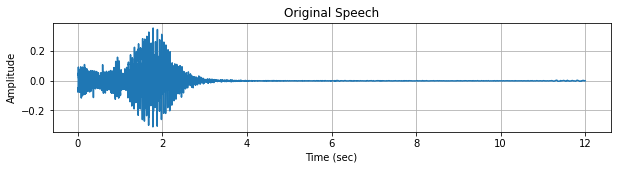

In [12]:
ys, sr = librosa.load('./Data/ZAhra.wav',10000)
yonsei = ys[12000:24000]
t_axis = np.linspace(0,12,12000)
plt.figure(figsize = (10,2))
plt.xlabel('Time (sec)')
plt.title('Original Speech')
plt.ylabel('Amplitude')
plt.grid(True)
plt.plot(t_axis, yonsei)

import IPython.display as ipd
ipd.Audio(yonsei, rate=10000, autoplay=True)

## Test: Pitch detection


Text(0.5, 1.0, 'Pitch contour')

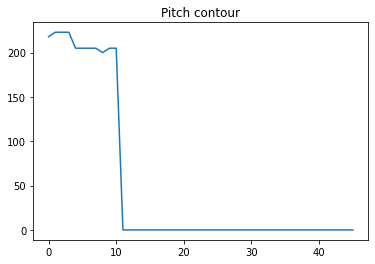

In [13]:
pitch = medianfilter(Pitch_detect(yonsei, np.ones(512), 10000,0.5,0.68,th_ = 0.3))
plt.plot(pitch)
plt.title('Pitch contour')

# Synthesis

In [14]:
def synthesis(signal,sr, window, p, overlap, c=0.68, th=0.3):
    """
    p: Order of the linear filter in LPC
    """
    length = len(window)
    
    '''padding'''
    shift = int(length*overlap)
    if len(signal) % shift != 0:                    
        pad = np.zeros(shift - (len(signal) % shift))  
        new_signal = np.append(signal, pad)                  
    else:
        new_signal = signal
        
    index = [j*shift for j in range(len(new_signal)//shift-1)]
    
    '''pitch detection'''
    pitch_contour = medianfilter(Pitch_detect(
        new_signal, np.ones(length), sr, overlap=overlap, center_clip=c, th_=th))
    
    '''voiced region index'''
    voiced_idx = [shift*i for i in range(len(pitch_contour)) if pitch_contour[i]>50]
    
    syn_signal = np.zeros((len(new_signal)))
    prev_V = False #Save whether previous region is voiced
 
    '''make excitation'''
    for idx in index: #for each window
        w_sig = new_signal[idx:idx+len(window)]*window
        
        if idx in voiced_idx: #Voiced: impulse train
            F0 = pitch_contour[int(idx/shift)]
            period = np.ceil(sr/F0)
            
            excitation = np.zeros((length))
            
            # If the previous area is unvoiced: excitation alignment X
            if not prev_V:
                found = False
                for k in range(length):
                    if k % period == 0:
                        excitation[k] = 1 #impulse train 
                        if not found and k > shift:
                            # Save the value considering the case where the next section is a voiced sound
                            alignpoint = k-shift
                            found = True
                prev_V = True
                        
            # If the previous area is voiced: excitation alignment O
            else:
                found = False
                for k in range(alignpoint,length):
                    if (k-alignpoint) % period ==0:
                        excitation[k] = 1
                        if not found and k > shift:
                            alignpoint = k-shift
                            found = True

        else: #Unvoiced: white noise
            sig_std = np.std(w_sig)
            excitation = np.random.normal(loc = 0.0, scale = sig_std, size = w_sig.shape)
            prev_V = False
            
        F_excitation = np.fft.fft(excitation, length)
        
        '''LPC spectrum'''
        LPC = Levinson(w_sig, p)
        LPC = np.insert(-LPC, 0, 1)
        w, h = scipy.signal.freqz([1],LPC,worN = length, whole = True, fs = sr)
        
        '''convolution in freq domain'''
        F_result = F_excitation*h
        result = np.fft.ifft(F_result, length)
        
        '''overlap-and-add'''
        syn_signal[idx:idx+length] += np.real(result)*np.hamming(length)
        
    return syn_signal
        
            
                        
            

## Visualization

In [15]:
import IPython.display as ipd

def visualize(signal,p):
    
    speech = synthesis(signal, 10000, np.hamming(256), p, 0.5, 0.6, 0.3)
    t_axis = np.linspace(0,len(speech)/sr,len(speech))
    
    plt.figure(figsize = (10,2))
    plt.grid(True)
    plt.xlabel('time (sec)')
    plt.title('Synthesized speech - LPC order: {}'.format(p))
    plt.plot(t_axis, speech)
    
    return speech

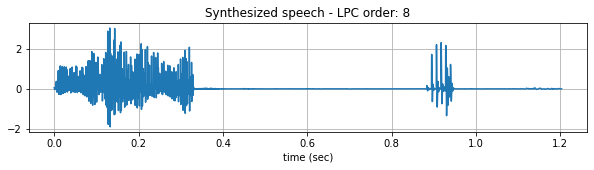

In [16]:
sp_8 = visualize(yonsei, 8)
    
ipd.Audio(sp_8, rate=10000, autoplay=True)

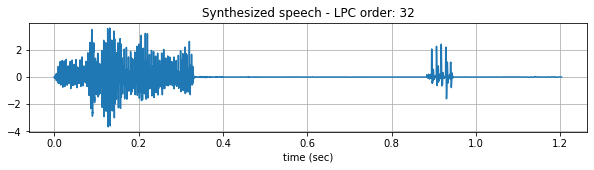

In [17]:
sp_32 = visualize(yonsei, 32)
    
ipd.Audio(sp_32, rate=10000, autoplay=True)